# Garbage image classification V2

We will try to get to a good result by using more images.

We are setting the imports that we need here at the top to have them in a single place

In [191]:
#import numpy for number array handling and represent rgb image pixel values
import numpy as np
import pandas as pd

#import tensorflow to use any tools needed for deep learning
import tensorflow as tf

#import keras api needed to implement deep learning techiques
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

#import libraries for visualization of data
import matplotlib.pyplot as plt

#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline

import os

# Set the environment variable
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from sklearn.model_selection import train_test_split

from PIL import Image

## Aggregating data, creating data set

We bring our folder images and we create a data frame.

In [30]:
def list_folders_in_directory(directory):
    folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    return folders

directory_path = "../v2/Garbage classification/"
folders_list = list_folders_in_directory(directory_path)
print(folders_list)

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']


In [31]:
data = []
for folder in folders_list: 
    files = os.listdir(os.path.join(directory_path, folder))
    #Add each file along with its folder name to the data list
    for file in files:
        data.append({'Folder': folder, 'File_name': file, 'Path':os.path.join(directory_path, folder, file)})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Display the DataFrame
df.head()



,Folder,File_name,Path
0,paper,paper903.jpg,../v2/Garbage classification/paper/paper903.jpg
1,paper,paper917.jpg,../v2/Garbage classification/paper/paper917.jpg
2,paper,paper724.jpg,../v2/Garbage classification/paper/paper724.jpg
3,paper,paper730.jpg,../v2/Garbage classification/paper/paper730.jpg
4,paper,paper718.jpg,../v2/Garbage classification/paper/paper718.jpg


We are getting some information about our images

In [32]:
def get_image_dimensions(df_row):
    file_path = os.path.join(directory_path, df_row['Folder'], df_row['File_name'])
    image = Image.open(file_path)
    width, height = image.size
    channels = image.mode
    return width, height, image.format, channels

df['Image_width'], df['Image_height'], df['Format'], df['Channels'] = zip(*df.apply(get_image_dimensions, axis=1))

df.head()

,Folder,File_name,Path,Image_width,Image_height,Format,Channels
0,paper,paper903.jpg,../v2/Garbage classification/paper/paper903.jpg,512,384,JPEG,RGB
1,paper,paper917.jpg,../v2/Garbage classification/paper/paper917.jpg,512,384,JPEG,RGB
2,paper,paper724.jpg,../v2/Garbage classification/paper/paper724.jpg,512,384,JPEG,RGB
3,paper,paper730.jpg,../v2/Garbage classification/paper/paper730.jpg,197,256,JPEG,RGB
4,paper,paper718.jpg,../v2/Garbage classification/paper/paper718.jpg,183,275,JPEG,RGB


We are looking at the format

In [33]:
df['Format'].value_counts()

Format
JPEG    6471
PNG       28
Name: count, dtype: int64

We are looking at the channels of the images.


In [34]:
df.Channels.value_counts()

Channels
RGB    6471
P        28
Name: count, dtype: int64


It seems that we have a format that will cause use some issues, since we will work with RGB channels. So we will remove them.

In [35]:
df = df.drop(df[df.Image_channel != 'RGB'].index)

In [36]:
df.Channels.value_counts()

Channels
RGB    6471
Name: count, dtype: int64

We can take a look to see how many images we are having on each class.

In [37]:
df.Folder.value_counts()

Folder
glass        2010
paper        1047
cardboard     890
plastic       865
metal         849
trash         810
Name: count, dtype: int64

It seems that the number of glass images is large compared to the other ones.

In [38]:
df[df.Folder == 'glass']

,Folder,File_name,Path,Image_width,Image_height,Format,Channels
3623,glass,brown-glass69.jpg,../v2/Garbage classification/glass/brown-glass...,225,225,JPEG,RGB
3624,glass,green-glass221.jpg,../v2/Garbage classification/glass/green-glass...,190,266,JPEG,RGB
3625,glass,white-glass345.jpg,../v2/Garbage classification/glass/white-glass...,225,225,JPEG,RGB
3626,glass,white-glass423.jpg,../v2/Garbage classification/glass/white-glass...,225,225,JPEG,RGB
3627,glass,green-glass547.jpg,../v2/Garbage classification/glass/green-glass...,259,194,JPEG,RGB
...,...,...,...,...,...,...,...
5629,glass,brown-glass3.jpg,../v2/Garbage classification/glass/brown-glass...,275,183,JPEG,RGB
5630,glass,white-glass348.jpg,../v2/Garbage classification/glass/white-glass...,230,219,JPEG,RGB
5631,glass,brown-glass64.jpg,../v2/Garbage classification/glass/brown-glass...,275,183,JPEG,RGB
5632,glass,brown-glass70.jpg,../v2/Garbage classification/glass/brown-glass...,225,225,JPEG,RGB


We can see that we have different glass colours and we want to remove some of them but to keep some sample from every glass type.

In [39]:
glass_df = df[df.Folder == 'glass']

white_glass_df = glass_df[glass_df['File_name'].str.contains("white")]
green_glass_df = glass_df[glass_df['File_name'].str.contains("green")]
brown_glass_df = glass_df[glass_df['File_name'].str.contains("brown")]

white_glass_df.shape, green_glass_df.shape, brown_glass_df.shape

((774, 7), (629, 7), (607, 7))

We will define a function that will randomly remove half of rows from a dataframe

In [40]:
def remove_glass_images(base_dataframe, dataframe):
    num_rows_to_remove = len(dataframe) // 2

    # Randomly select rows to remove
    rows_to_remove = np.random.choice(dataframe.index, size=num_rows_to_remove, replace=False)

    # Remove selected rows from the original DataFrame
    base_dataframe = base_dataframe.drop(rows_to_remove)

    return base_dataframe

Now we will use that function on our coloured glass dataframes.

In [41]:
df = remove_glass_images(df, white_glass_df)
df = remove_glass_images(df, green_glass_df)
df = remove_glass_images(df, brown_glass_df)

df.Folder.value_counts()

Folder
paper        1047
glass        1006
cardboard     890
plastic       865
metal         849
trash         810
Name: count, dtype: int64

Now that our images are more balanced we can group them so we can easily split them in training data, validation data and test data

In [42]:
grouped = df.groupby('Folder')

grouped.head(1)

,Folder,File_name,Path,Image_width,Image_height,Format,Channels
0,paper,paper903.jpg,../v2/Garbage classification/paper/paper903.jpg,512,384,JPEG,RGB
1050,metal,metal296.jpg,../v2/Garbage classification/metal/metal296.jpg,512,384,JPEG,RGB
1899,cardboard,cardboard555.jpg,../v2/Garbage classification/cardboard/cardboa...,225,225,JPEG,RGB
2789,trash,trash15 (2).jpg,../v2/Garbage classification/trash/trash15 (2)...,512,384,JPEG,RGB
3624,glass,green-glass221.jpg,../v2/Garbage classification/glass/green-glass...,190,266,JPEG,RGB
5634,plastic,plastic391.jpg,../v2/Garbage classification/plastic/plastic39...,512,384,JPEG,RGB


We are creating a dataframe that we will use to test our model.

In [43]:
test_set = pd.DataFrame()

# Iterate over each group
for name, group in grouped:
    # Split each group into train and test sets while maintaining the proportions
    train, test = train_test_split(group, test_size=0.1, random_state=42)  # Adjust test_size as needed
    # Append the test set from the current group to the test_set DataFrame
    test_set = pd.concat([test_set, test])


We can check how many images we have in our test dataframe.

In [44]:
test_set.Folder.value_counts()

Folder
paper        105
glass        101
cardboard     89
plastic       87
metal         85
trash         81
Name: count, dtype: int64

We are removing the test images from the initial dataframe.

In [45]:
df = df.drop(test_set.index)
df.Folder.value_counts()

Folder
paper        942
glass        905
cardboard    801
plastic      778
metal        764
trash        729
Name: count, dtype: int64

We are also creating a dataframe that we will use to validate our model.

In [46]:
validation_set = pd.DataFrame()
grouped = df.groupby('Folder')

# Iterate over each group
for name, group in grouped:
    # Split each group into train and test sets while maintaining the proportions
    train, test = train_test_split(group, test_size=0.2, random_state=42)  # Adjust test_size as needed
    # Append the test set from the current group to the test_set DataFrame
    validation_set = pd.concat([validation_set, test])


We can check how many images we have in our validation dataframe.

In [47]:
validation_set.Folder.value_counts()

Folder
paper        189
glass        181
cardboard    161
plastic      156
metal        153
trash        146
Name: count, dtype: int64

We will remove the validation images from our original dataset.

In [48]:
df = df.drop(validation_set.index)
df.Folder.value_counts()

Folder
paper        753
glass        724
cardboard    640
plastic      622
metal        611
trash        583
Name: count, dtype: int64

We will reset our indexes in all the created dataframes

In [49]:
df.reset_index(drop=True,inplace=True)
validation_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True,inplace=True)

What remained in the initial dataframe will be used for training the model.

In [50]:
df.Folder.value_counts()

Folder
paper        753
glass        724
cardboard    640
plastic      622
metal        611
trash        583
Name: count, dtype: int64

We will create batches of data for train and validation from our dataframes.

Even if we use an ImageDataGenerator that is used for augmentation we will only rescale the values from the images at this point.

In [51]:
image_height = 150
image_width = 150

train_batches = ImageDataGenerator(
    rescale=1./255.,
    ).flow_from_dataframe(
    dataframe=df, 
    x_col = 'Path',
    y_col = 'Folder',
    target_size=(image_height,image_width),
    shuffle=True, 
    class_mode='sparse', 
    batch_size=32)


# extract images to validation set
valid_batches = ImageDataGenerator(
     rescale=1./255.,
   ).flow_from_dataframe(
    dataframe=validation_set,
    x_col = 'Path',
    y_col = 'Folder', 
    target_size=(image_height,image_width),
    shuffle=True, 
    class_mode='sparse', 
    batch_size=32)



Found 3933 validated image filenames belonging to 6 classes.
Found 986 validated image filenames belonging to 6 classes.


# Model CNN

We are creating the model

In [52]:
model = Sequential([
    Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(image_height, image_width, 3)),  # Input
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64),
    Dropout(0.2),
    Dense(6)  # 6 classes
])

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 32)      

Compiling the model

In [54]:
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss=SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

Creating a function to save only the best model

In [55]:
def create_model_checkpoint(model_path):
    model_checkpoint = ModelCheckpoint(f"../models/{model_path}", monitor='val_accuracy', verbose=1, save_best_only=True)
    return model_checkpoint

Training the model

In [56]:
model_details = model.fit(x=train_batches, validation_data=valid_batches, epochs=30, callbacks=[create_model_checkpoint("initial_model_v2.h5")])

Epoch 1/30


123/123 [==============================] - ETA: 0s - loss: 1.6431 - accuracy: 0.3239
Epoch 1: val_accuracy improved from -inf to 0.47160, saving model to initial_model_v2.h5
123/123 [==============================] - 53s 409ms/step - loss: 1.6431 - accuracy: 0.3239 - val_loss: 1.2896 - val_accuracy: 0.4716
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 1.3755 - accuracy: 0.4475
Epoch 2: val_accuracy improved from 0.47160 to 0.52637, saving model to initial_model_v2.h5
123/123 [==============================] - 54s 443ms/step - loss: 1.3755 - accuracy: 0.4475 - val_loss: 1.2329 - val_accuracy: 0.5264
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 1.2305 - accuracy: 0.5261
Epoch 3: val_accuracy improved from 0.52637 to 0.58316, saving model to initial_model_v2.h5
123/123 [==============================] - 55s 443ms/step - loss: 1.2305 - accuracy: 0.5261 - val_loss: 1.1192 - val_accuracy: 0.5832
Epoch 4/30
123/123 [============================

We can see that we have an improvement from the other version where we had a lower validation accuracy at this point.

We will try to augment the data that we have to see if the performance is improving

In [58]:
train_batches = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    ).flow_from_dataframe(
    dataframe=df, 
    x_col = 'Path',
    y_col = 'Folder',target_size=(image_height,image_width),shuffle=True, class_mode='sparse', batch_size=32)


# extract images to validation set
valid_batches = ImageDataGenerator(
     rescale=1./255.,
   ).flow_from_dataframe(
    dataframe=validation_set,
    x_col = 'Path',
    y_col = 'Folder', target_size=(image_height,image_width),shuffle=True, class_mode='sparse', batch_size=32)

Found 3933 validated image filenames belonging to 6 classes.


Found 986 validated image filenames belonging to 6 classes.


We are loading the model

In [57]:
model = tf.keras.models.load_model("../models/initial_model_v2.h5")

We will compile again the model and we train

In [59]:
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss=SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

In [60]:
model_details = model.fit(x=train_batches, validation_data=valid_batches, epochs=20, callbacks=[create_model_checkpoint("initial_model_v2.h5")])

Epoch 1/20
123/123 [==============================] - ETA: 0s - loss: 1.4403 - accuracy: 0.4889
Epoch 1: val_accuracy improved from -inf to 0.64909, saving model to initial_model_v2.h5
123/123 [==============================] - 60s 477ms/step - loss: 1.4403 - accuracy: 0.4889 - val_loss: 1.0097 - val_accuracy: 0.6491
Epoch 2/20
123/123 [==============================] - ETA: 0s - loss: 1.2024 - accuracy: 0.5561
Epoch 2: val_accuracy improved from 0.64909 to 0.65517, saving model to initial_model_v2.h5
123/123 [==============================] - 58s 468ms/step - loss: 1.2024 - accuracy: 0.5561 - val_loss: 0.9981 - val_accuracy: 0.6552
Epoch 3/20
123/123 [==============================] - ETA: 0s - loss: 1.1615 - accuracy: 0.5726
Epoch 3: val_accuracy improved from 0.65517 to 0.68560, saving model to initial_model_v2.h5
123/123 [==============================] - 56s 457ms/step - loss: 1.1615 - accuracy: 0.5726 - val_loss: 0.9055 - val_accuracy: 0.6856
Epoch 4/20
123/123 [=================

We load the model with validation of 0.74341 and we decrease the learning rate and we train again trying to increase the accuracy.

In [248]:

loaded_model = tf.keras.models.load_model('../models/initial_model_v2.h5')

In [62]:
loaded_model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss=SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

In [63]:
model_details = loaded_model.fit(x=train_batches, validation_data=valid_batches, epochs=30, callbacks=[create_model_checkpoint("initial_model_v2.h5")])

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7964 - accuracy: 0.7196
Epoch 1: val_accuracy improved from -inf to 0.74239, saving model to initial_model_v2.h5
123/123 [==============================] - 51s 404ms/step - loss: 0.7964 - accuracy: 0.7196 - val_loss: 0.7586 - val_accuracy: 0.7424
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.7923 - accuracy: 0.7213
Epoch 2: val_accuracy improved from 0.74239 to 0.75051, saving model to initial_model_v2.h5
123/123 [==============================] - 50s 403ms/step - loss: 0.7923 - accuracy: 0.7213 - val_loss: 0.7454 - val_accuracy: 0.7505
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.7470 - accuracy: 0.7267
Epoch 3: val_accuracy did not improve from 0.75051
123/123 [==============================] - 50s 402ms/step - loss: 0.7470 - accuracy: 0.7267 - val_loss: 0.7567 - val_accuracy: 0.7465
Epoch 4/30
123/123 [==============================] - ETA: 0s - loss: 0.7683 -

We evaluate the model and we see that we have an improvement of 0.76 validation

In [68]:
loaded_model.evaluate(valid_batches)

31/31 [==============================] - 3s 107ms/step - loss: 0.7356 - accuracy: 0.7596


[0.7355844974517822, 0.7596349120140076]

We are adding Softmax layer to the original model to interpret the results.

In [69]:
probability_model = tf.keras.Sequential([loaded_model, 
                                         tf.keras.layers.Softmax()])

We make predictions

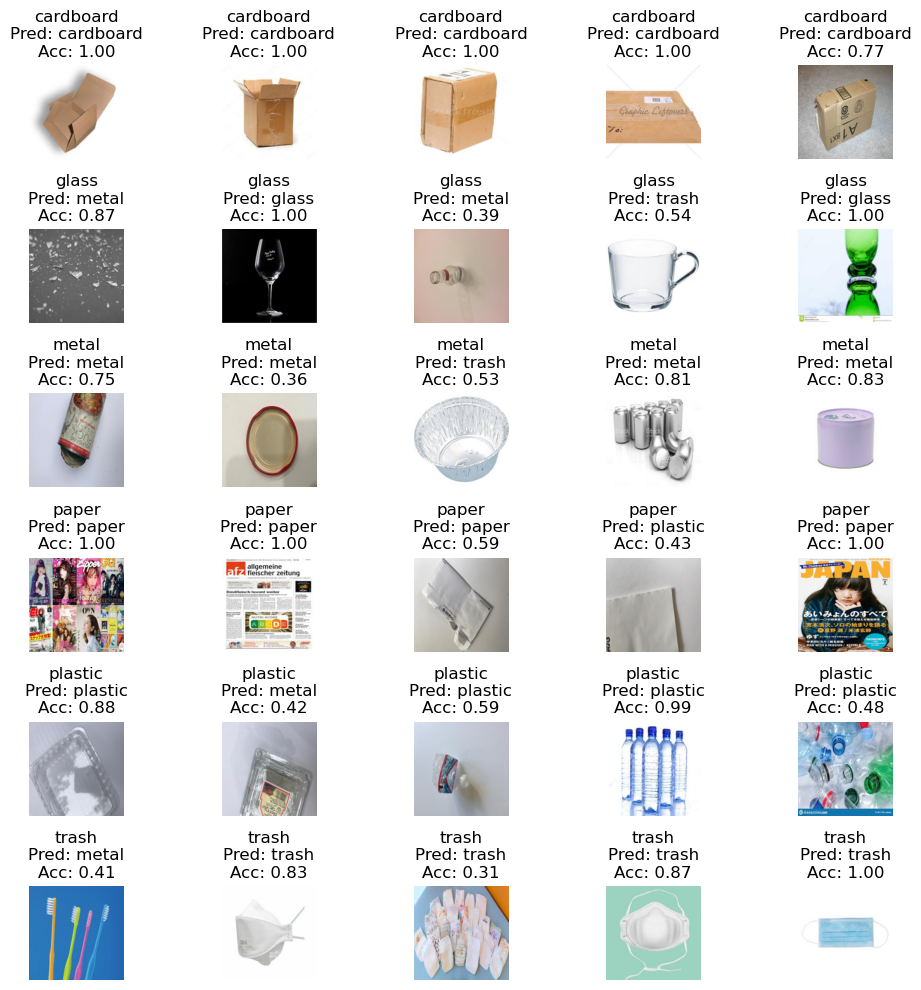

In [70]:
import os
import matplotlib.pyplot as plt
from PIL import Image

#data_directory = "validation_images"

#probability_model = tf.keras.models.load_model('../models\model_pretrained.h5')
test_set = test_set.sample(frac=1, random_state=42)
class_names = sorted(test_set.Folder.unique())

plt.figure(figsize=(10, 10))
new_dataset = pd.DataFrame()
num_images_per_class = 5
grouped = test_set.groupby("Folder")
new_dataset = grouped.head(num_images_per_class)
new_dataset.reset_index(drop=True, inplace=True)

for class_index, class_name in enumerate(class_names):
    class_images = []
    class_predictions =[]
    class_accuracy =[]
    
    #class_path = os.path.join(data_directory, class_name)
    for index, row in new_dataset[new_dataset.Folder == class_name].iterrows():
        img_path = row['Path']
        image = Image.open(img_path)

        image = image.resize((150, 150))  # Replace 'width' and 'height' with desired dimensions

            # Convert the image to a numpy array
        image_array = np.array(image)

            # Convert the numpy array to a TensorFlow tensor
        image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32) / 255.0

            # Expand the dimensions of the tensor to match the expected input shape
        image_tensor = tf.expand_dims(image_tensor, axis=0)
            
        predictions = probability_model.predict(image_tensor, verbose=0)
        predicted_index = np.argmax(predictions)
        predicted_label = class_names[predicted_index]
        accuracy = np.round(np.max(predictions), 2)
        class_images.append(image)
        class_predictions.append("\nPred: "+ predicted_label)
        class_accuracy.append(f"\nAcc: {accuracy:.2f}")
    
    for k in range(num_images_per_class):
        if k < len(class_images):
            plt.subplot(len(class_names), num_images_per_class, class_index * num_images_per_class + k + 1)
            plt.imshow(class_images[k])
            plt.title(class_name + class_predictions[k] + class_accuracy[k])
            plt.axis("off")

plt.tight_layout()
plt.show()

# Inception V3

We create the model

In [179]:
iv3_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(250, 250, 3),
)

We block the layers of the pretrained model to not be trainable.

In [180]:
iv3_model.trainable = False
iv3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_760 (Conv2D)            (None, 124, 124, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_771 (Batch  (None, 124, 124, 32  96         ['conv2d_760[0][0]']             
 Normalization)                 )                                                      

We define the Top Layers(Head layers)

In [181]:
x = iv3_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(iv3_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(6)(x)

We attach the top layer and create a model

In [182]:
pretrained_model = Model(inputs=iv3_model.input, outputs=predictions)
pretrained_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_760 (Conv2D)            (None, 124, 124, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_771 (Batch  (None, 124, 124, 32  96         ['conv2d_760[0][0]']             
 Normalization)                 )                                                          

                                                                                                  
 average_pooling2d_73 (AverageP  (None, 28, 28, 256)  0          ['mixed0[0][0]']                 
 ooling2D)                                                                                        
                                                                                                  
 conv2d_772 (Conv2D)            (None, 28, 28, 64)   16384       ['mixed0[0][0]']                 
                                                                                                  
 conv2d_774 (Conv2D)            (None, 28, 28, 64)   76800       ['activation_765[0][0]']         
                                                                                                  
 conv2d_777 (Conv2D)            (None, 28, 28, 96)   82944       ['activation_768[0][0]']         
                                                                                                  
 conv2d_77

We can augment our data but to apply a preprocessing function that will convert our data to match our pretrained_model

In [183]:
directory_path = "../v2/Garbage classification/"

image_width = 250
image_height = 250
image_size = (image_width, image_height)
batch_size = 32

train_batches_v3 = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1, 
    ).flow_from_directory(
    directory=directory_path, target_size=image_size,shuffle=True, class_mode="sparse", batch_size=32, subset='training')


# extract images to validation set
valid_batches_v3 = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    validation_split=0.1).flow_from_directory(
    directory=directory_path, target_size=image_size, shuffle = False, class_mode="sparse", batch_size=32, subset='validation')

Found 5851 images belonging to 6 classes.
Found 648 images belonging to 6 classes.


We compile and train the model with augumentation

In [184]:
pretrained_model.compile(
    optimizer=Adam(), 
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

In [185]:
history_pretrained = pretrained_model.fit(x=train_batches_v3, validation_data=valid_batches_v3, epochs=20, callbacks=[create_model_checkpoint("pretrained_model_v2.h5")])

Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.8058
Epoch 1: val_accuracy improved from -inf to 0.83488, saving model to pretrained_model_v2.h5
183/183 [==============================] - 298s 2s/step - loss: 0.5707 - accuracy: 0.8058 - val_loss: 0.4723 - val_accuracy: 0.8349
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.3680 - accuracy: 0.8691
Epoch 2: val_accuracy did not improve from 0.83488
183/183 [==============================] - 328s 2s/step - loss: 0.3680 - accuracy: 0.8691 - val_loss: 0.5292 - val_accuracy: 0.8179
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.8872
Epoch 3: val_accuracy did not improve from 0.83488
183/183 [==============================] - 283s 2s/step - loss: 0.3148 - accuracy: 0.8872 - val_loss: 0.4670 - val_accuracy: 0.8349
Epoch 4/20
183/183 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.9010
Epoch 4: val_accuracy impr

We define a method to plot our training history.

In [186]:
def plot_validation_training(history):

    acc = history['accuracy']
    val_acc = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs = len(acc)
    epochs_range = range(1, epochs +1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

We take a look how training and validation behave.

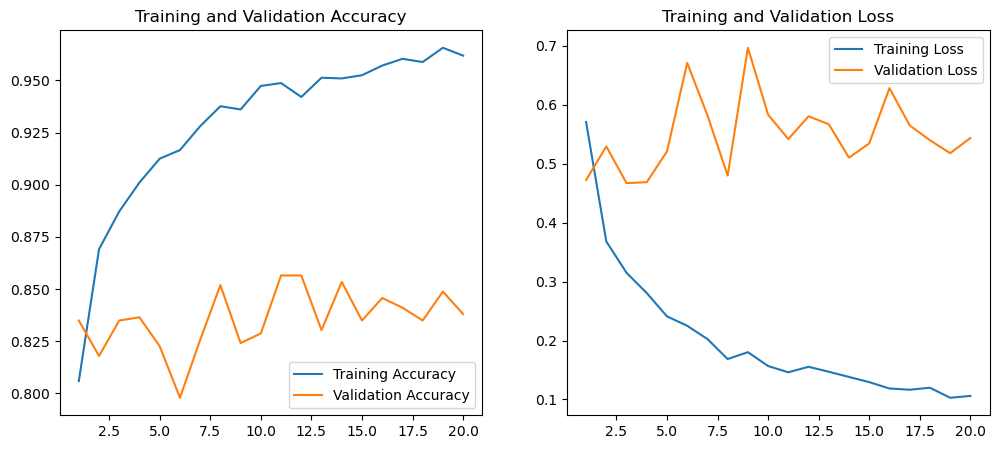

In [187]:
plot_validation_training(history_pretrained.history)

Another thing that we can do is to unfreeze more layers so that our model can learn more.

In [192]:
pretrained_model = tf.keras.models.load_model("../models/pretrained_model_v2.h5")

pretrained_model.trainable = True
pretrained_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_760 (Conv2D)            (None, 124, 124, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_771 (Batch  (None, 124, 124, 32  96         ['conv2d_760[0][0]']             
 Normalization)                 )                                                          

Then we will choose to train the top 2 inception blocks, we will freeze the first 249 layers.

In [193]:
for layer in pretrained_model.layers[:249]:
    layer.trainable = False

pretrained_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_760 (Conv2D)            (None, 124, 124, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_771 (Batch  (None, 124, 124, 32  96         ['conv2d_760[0][0]']             
 Normalization)                 )                                                          

We compile and train the model

In [194]:
pretrained_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

In [195]:
more_layers_model_history = pretrained_model.fit(x=train_batches_v3, validation_data=valid_batches_v3, epochs=20, callbacks=[create_model_checkpoint("pretrained_model.h5")])

Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.4889 - accuracy: 0.8431
Epoch 1: val_accuracy improved from -inf to 0.85494, saving model to pretrained_model.h5
183/183 [==============================] - 297s 2s/step - loss: 0.4889 - accuracy: 0.8431 - val_loss: 0.4616 - val_accuracy: 0.8549
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.9106
Epoch 2: val_accuracy improved from 0.85494 to 0.86111, saving model to pretrained_model.h5
183/183 [==============================] - 289s 2s/step - loss: 0.2737 - accuracy: 0.9106 - val_loss: 0.4673 - val_accuracy: 0.8611
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9332
Epoch 3: val_accuracy improved from 0.86111 to 0.87191, saving model to pretrained_model.h5
183/183 [==============================] - 387s 2s/step - loss: 0.1985 - accuracy: 0.9332 - val_loss: 0.4069 - val_accuracy: 0.8719
Epoch 4/20
183/183 [=======================

We load the model and we will train it again with a lower learning rate

In [202]:
pretrained_model = tf.keras.models.load_model("../models/pretrained_model.h5")

In [203]:
pretrained_model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

In [204]:
finetune_more_layers_model_history = pretrained_model.fit(x=train_batches_v3, validation_data=valid_batches_v3, epochs=20, callbacks=[create_model_checkpoint("pretrained_model.h5")])

Epoch 1/20
183/183 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9925
Epoch 1: val_accuracy improved from -inf to 0.91512, saving model to pretrained_model.h5
183/183 [==============================] - 373s 2s/step - loss: 0.0193 - accuracy: 0.9925 - val_loss: 0.3875 - val_accuracy: 0.9151
Epoch 2/20
183/183 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9961
Epoch 2: val_accuracy did not improve from 0.91512
183/183 [==============================] - 371s 2s/step - loss: 0.0123 - accuracy: 0.9961 - val_loss: 0.3908 - val_accuracy: 0.9136
Epoch 3/20
183/183 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9964
Epoch 3: val_accuracy improved from 0.91512 to 0.91975, saving model to pretrained_model.h5
183/183 [==============================] - 407s 2s/step - loss: 0.0111 - accuracy: 0.9964 - val_loss: 0.4323 - val_accuracy: 0.9198
Epoch 4/20
183/183 [==============================] - ETA: 0s - loss: 0.0072 - accur

In [205]:
pretrained_model = tf.keras.models.load_model("../models/pretrained_model.h5")

probability_model = tf.keras.Sequential([pretrained_model, 
                                         tf.keras.layers.Softmax()])

We define a method to plot the confusion matrix.

In [206]:
def plot_confusion_matrix(batches, actual_labels, predicted_labels):
    class_= valid_batches.class_indices.keys()
    cm = confusion_matrix(actual_labels, predicted_labels)

    fig = plt.figure(figsize=(8, 6))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,cmap="BuPu"); 
    ax.set_xlabel('Predicted classes', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('Actual classes', fontsize=20)
    ax.yaxis.set_ticklabels(class_, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('', fontsize=60)

    plt.show()

We define a method to get the data from the batches one row at a time.

In [207]:
def prediction_generator(test_images):
    k = 0
    for x in test_images:
        k += len(x[1])
        yield x[0], x[1]  # Passing single tensor to the model
        if k >= test_images.n:
            break

We are generating the test batch

In [208]:
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
   ).flow_from_dataframe(
    dataframe=test_set,
    x_col = 'Path',
    y_col = 'Folder', target_size=(224,224),shuffle=False, class_mode='sparse', batch_size=16)

Found 548 validated image filenames belonging to 6 classes.


Using the model to make predictions on the test batch

In [209]:
probabilities = probability_model.predict(prediction_generator(valid_batches))

predicted_labels = np.argmax(probabilities, axis=1)

actual_labels=valid_batches.labels
accuracy_score(predicted_labels, actual_labels)

21/21 [==============================] - 19s 807ms/step


0.9243827160493827

We plot the prediction using a confusion matrix.

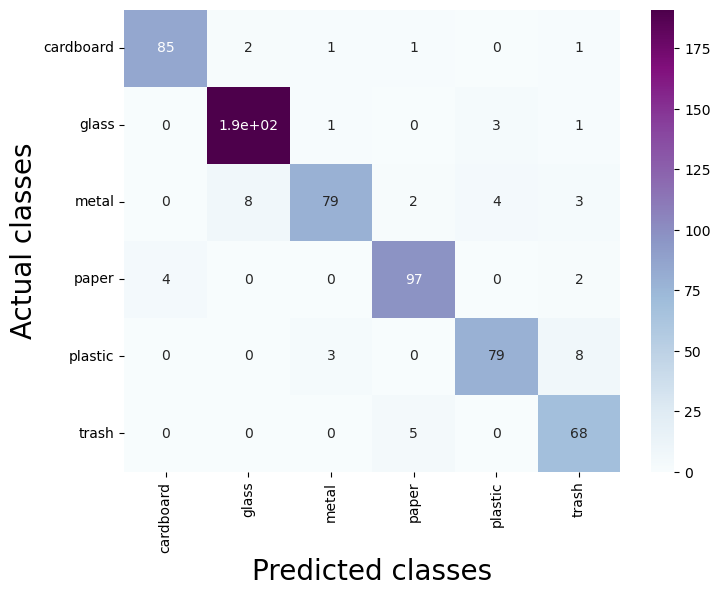

In [210]:
plot_confusion_matrix(valid_batches, predicted_labels, actual_labels)

Here we create a method to make predictions with unseen data.

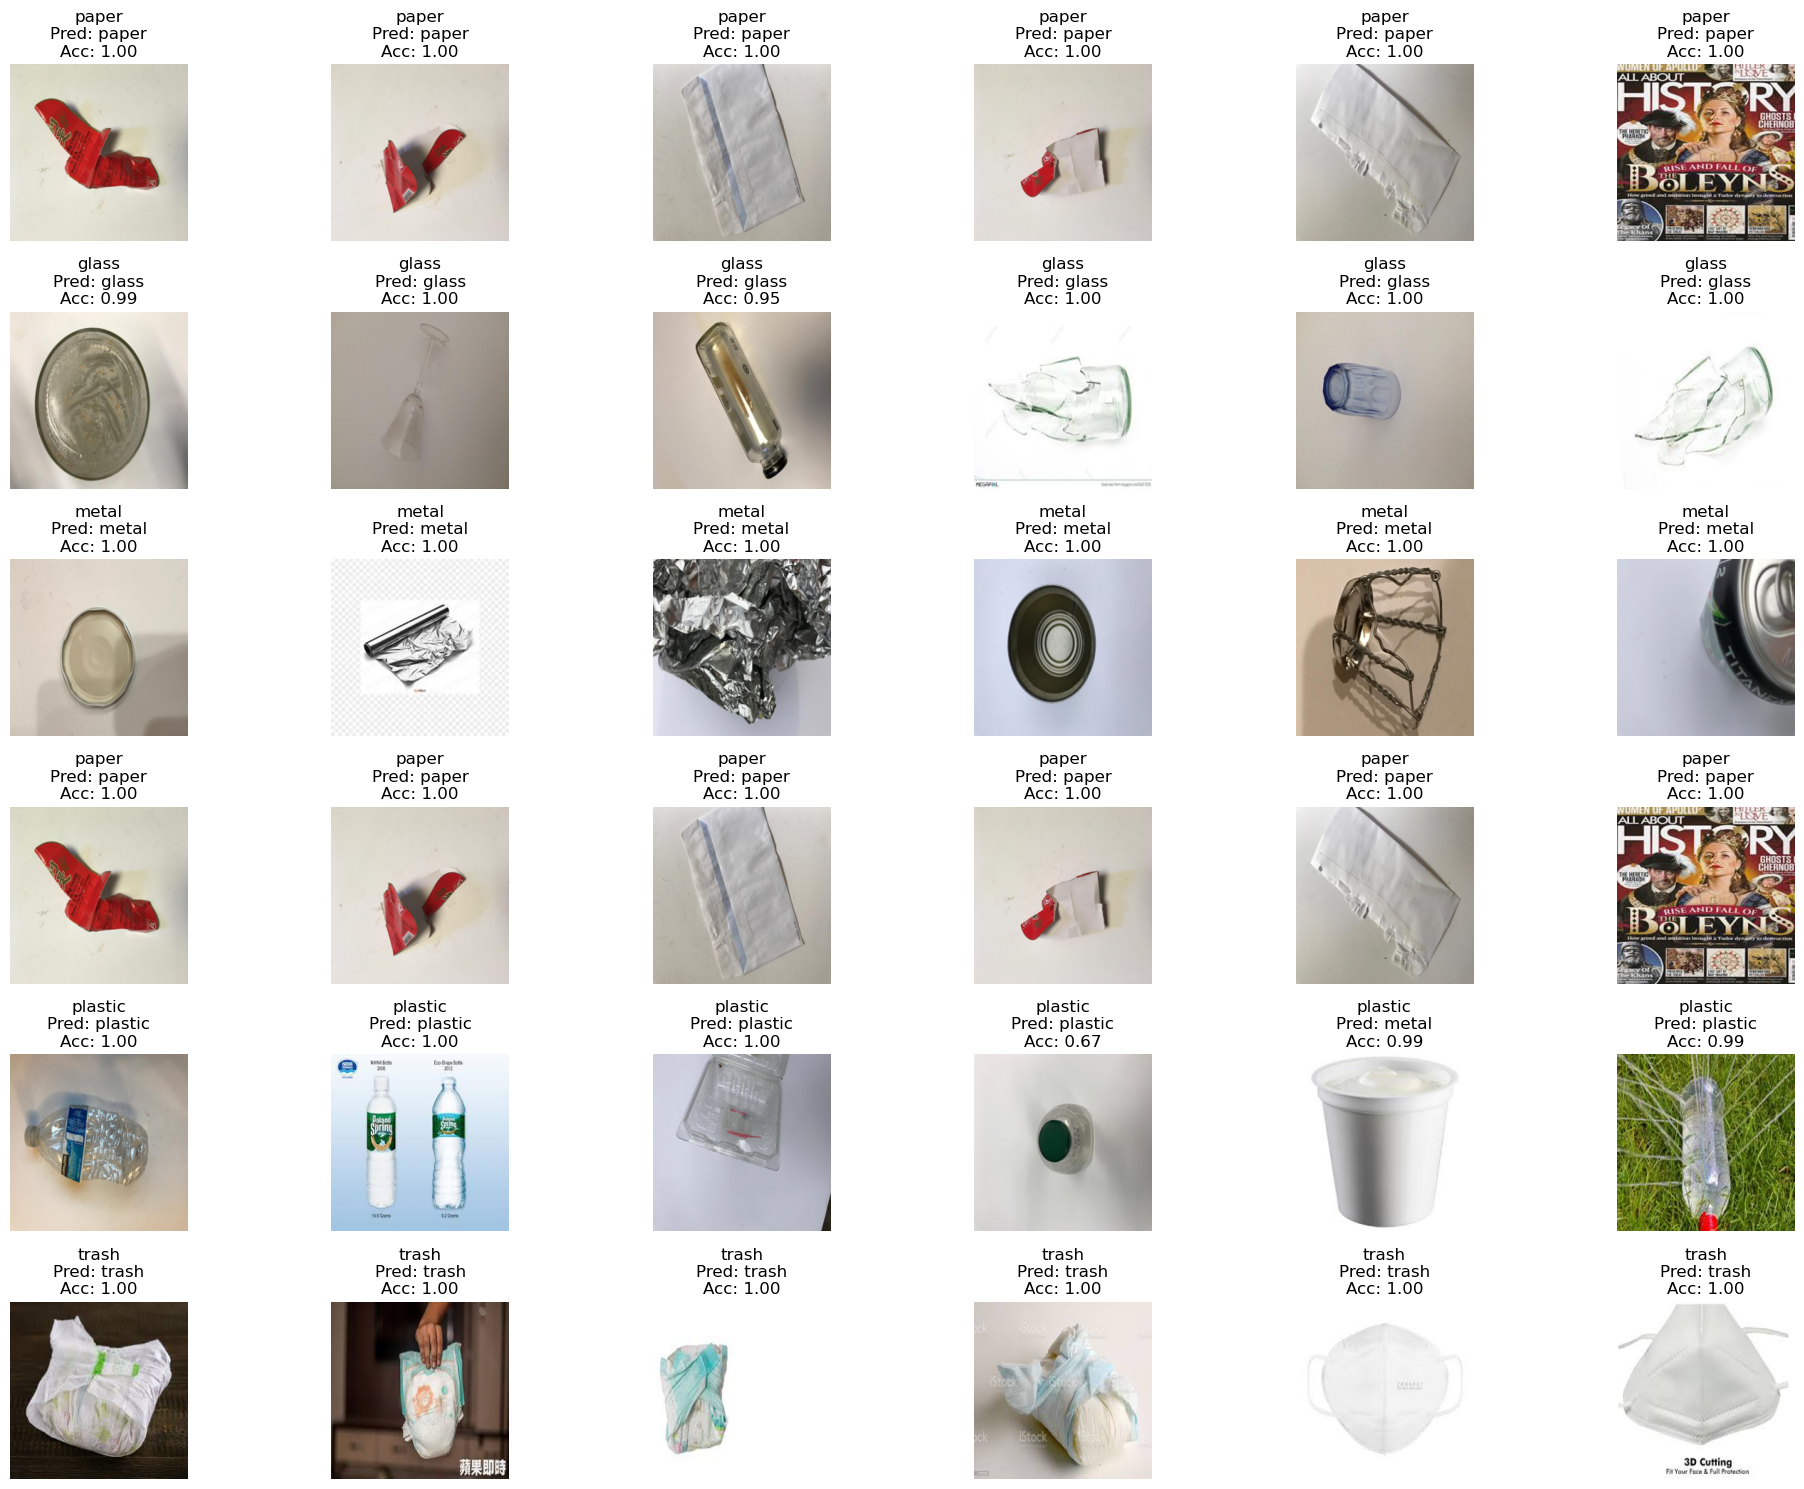

In [236]:
import os
import matplotlib.pyplot as plt
from PIL import Image

data_directory = "../validation_images"

class_names = [name for name in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, name))]

plt.figure(figsize=(20, 15))

num_images_per_class = 6

for class_index, class_name in enumerate(class_names):
    class_names.sort(reverse=False)
    class_images = []
    class_predictions =[]
    class_accuracy =[]
    class_path = os.path.join(data_directory, class_name)
    for img_name in os.listdir(class_path)[:num_images_per_class]:
        if img_name != ".DS_Store":  # Skip non-directory files
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path)

            image = image.resize(image_size)  # Replace 'width' and 'height' with desired dimensions

            # Convert the image to a numpy array
            image_array = np.array(image)

            # Convert the numpy array to a TensorFlow tensor
            image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32) / 255.0

            # Expand the dimensions of the tensor to match the expected input shape
            image_tensor = tf.expand_dims(image_tensor, axis=0)
            
            predictions = probability_model.predict(image_tensor, verbose=0)
            predicted_index = np.argmax(predictions)
            predicted_label = class_names[predicted_index]
            accuracy = np.round(np.max(predictions), 2)
            class_images.append(image)
            class_predictions.append("\nPred: "+ predicted_label)
            class_accuracy.append(f"\nAcc: {accuracy:.2f}")
    
    for k in range(num_images_per_class):
        if k < len(class_images):
            plt.subplot(len(class_names), num_images_per_class, class_index * num_images_per_class + k + 1)
            plt.imshow(class_images[k])
            plt.title(class_name + class_predictions[k] + class_accuracy[k])
            plt.axis("off")

plt.tight_layout()
plt.show()

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
